# 1. Import lib and Data

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

try:
  os.chdir('drive/MyDrive/Миграция/HR_CV/myTarget/')
except:
  True

os.listdir()

['myTarget_HW.ipynb',
 'python_task_dataset.csv',
 'task_python.docx',
 'catboost_info']

В файле находятся данные по показам и кликам рекламы одного рекламодателя в двух регионах.

### Описание данных:

#### Device:
* Device_id – уникальный идентификатор девайса отправителя события
* Device_type – тип девайса

#### Event:
* Datetime – время отправки события
* Ev_type – тип события (0 – показ, 1 – клик)

#### Adv:
* Adv_type – тип рекламы

#### User:
* Region_id – регион отправителя события
* Age – возраст отправителя события
* Gender – пол отправителя события (1 – женщины, 2 – мужчины)

### На основе имеющихся данных сформулируйте рекомендации для рекламодателя: 
какие дополнительные настройки нужно добавить в рекламные кампании, чтобы улучшить их эффективность (например, выставить таргетинги на отдельные группы пользователей, ограничить время показа рекламы и т.д.).

### В ходе исследования
используйте разные подходы: например, кластеризуйте юзеров или обучите классификатор для целевого действия.

### В качестве решения 
необходимо прислать код на python и рекомендации (с таблицами/графиками/т.п.).


In [2]:
df1 = pd.read_csv('python_task_dataset.csv')
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1

,device_id,device_type,datetime,ev_type,adv_type,region_id,age,gender
0,100001,android,2019-03-01 15:58:02,0,multi,2,14,2
1,100001,android,2019-03-01 17:13:53,0,multi,2,14,2
2,100002,android,2019-03-01 23:13:25,0,multi,2,0,0
3,100002,android,2019-03-01 23:25:06,0,multi,2,0,0
4,100003,android,2019-03-01 15:27:53,0,multi,1,0,0
...,...,...,...,...,...,...,...,...
265398,287154,android,2019-03-08 16:23:09,0,video,2,31,1
265399,287155,android,2019-03-08 15:09:58,0,video,1,52,1
265400,287156,android,2019-03-08 18:13:27,0,video,1,20,1
265401,287157,android,2019-03-08 15:48:19,0,video,1,25,1


# 2. View DATA

In [3]:
df1.describe()

,device_id,ev_type,region_id,age,gender
count,265403.000000,265403.000000,265403.000000,265403.000000,265403.000000
mean,180685.732791,0.015478,1.204941,28.562051,0.932529
std,55776.059535,0.123446,0.403659,15.912911,0.376287
min,100001.000000,0.000000,1.000000,0.000000,0.000000
25%,130828.000000,0.000000,1.000000,21.000000,1.000000
50%,176487.000000,0.000000,1.000000,29.000000,1.000000
75%,228103.500000,0.000000,1.000000,38.000000,1.000000
max,287158.000000,1.000000,2.000000,75.000000,2.000000


In [4]:
df1.describe(include=['object', 'bool','datetime'])

,device_type,datetime,adv_type
count,265403,265403,265403
unique,2,193217,2
top,android,2019-03-08 17:30:21,video
freq,228595,10,213993
first,NaN,2019-03-01 00:00:01,NaN
last,NaN,2019-03-09 23:59:56,NaN


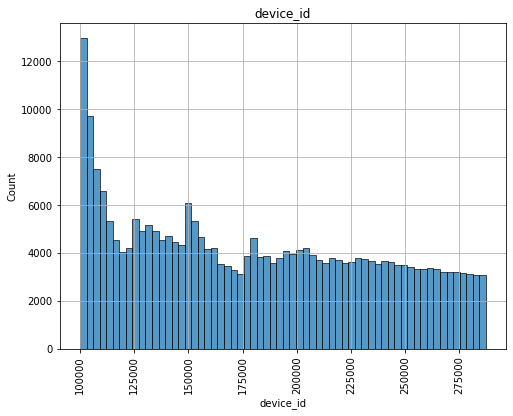

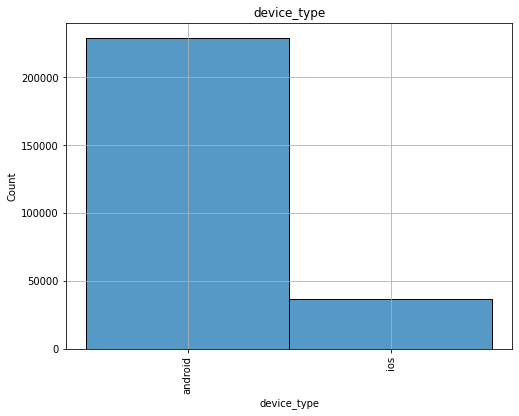

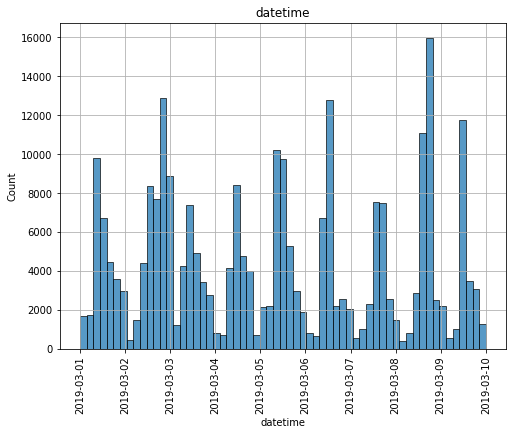

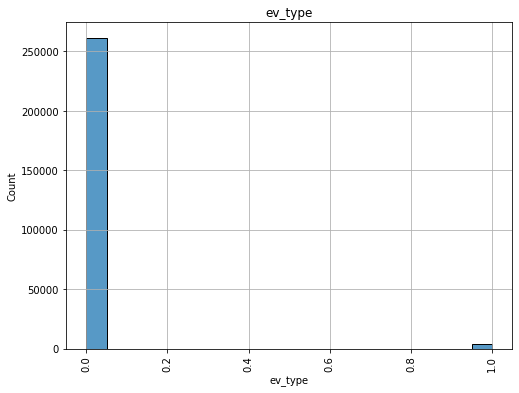

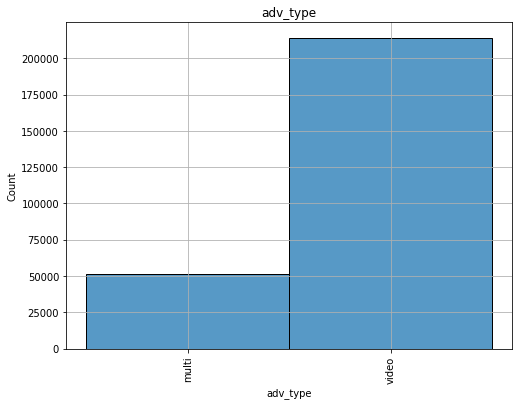

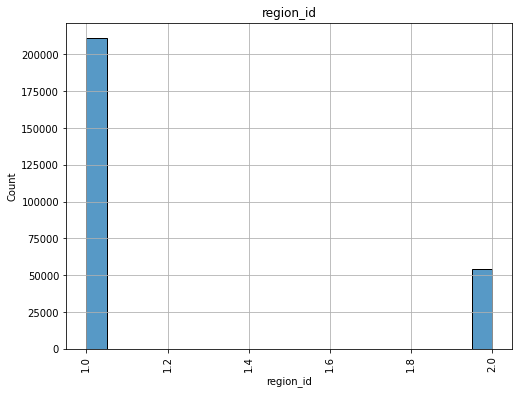

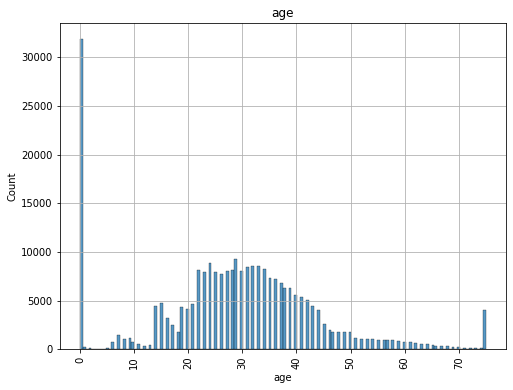

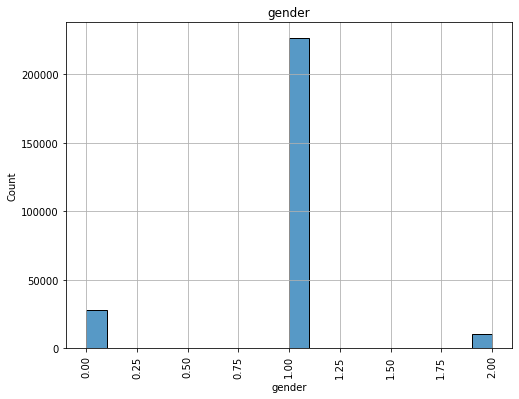

In [5]:
for col in df1.columns:
  plt.figure(figsize=(8,6))
  sns.histplot( data=df1, x=col )
  plt.title(col)
  plt.xticks(rotation=90)
  plt.grid(True)
  plt.show()
  print()

Выводы по графикам:
- Device_type – большая часть записей сидят с Android, остальные с iPhone
- Datetime – наблюдается суточная сезонность, данные за 9 дней февраля 2019 года
- Ev_type – показы+клики (=1) в разы меньше показов (=0)
- Adv_type – больше показов в формате "video"
- Region_id – всего  два региона 1 и 2, предпочительно =1
- Age – видим пропуски в данных =0, в остальном близкое к нормальному распределение
- Gender – небольшие пропуски в данных =0, в остальном преобладает =1


# 3. Разделим датасет на две группы по device_id: 
- device_id0 - у device_id был только Показ (т.е. нет ни одного Клик)
- device_id1 - Показ+Клик (т.е. есть хотя бы один Клик)

In [6]:
df_tmp = df1.groupby(['device_id'])[['ev_type']].max() \
  .reset_index().sort_values(['ev_type','device_id']) \
  .reset_index( drop=True )

device_id1 = [ x for x in df_tmp[df_tmp['ev_type']==1]['device_id'].values ]
device_id0 = [ x for x in df_tmp[df_tmp['ev_type']==0]['device_id'].values ]

print( 'device_id ev_type=1', len(device_id1))
print( 'device_id ev_type=0', len(device_id0),  )

device_id ev_type=1 4042
device_id ev_type=0 183116


In [7]:
columns = ['device_type', 'adv_type', 
           'region_id', 'age', 'gender']

df1_0 = df1[ df1['device_id'].isin(device_id0) ].copy()
df1_0['target']=0

df1_1 = df1[ df1['device_id'].isin(device_id1) ].copy()
df1_1['target']=1

df2 = df1_0.append(df1_1).reset_index(drop=True)

print(df1_0.shape, df1_1.shape, df2.shape)

(254788, 9) (10615, 9) (265403, 9)


#### Проверим, чтобы на каждый device_id был один профиль с однозначными признаками
Если таких менее 1% - то исключаем

In [8]:
df_check = df1_0 \
  .groupby(['device_id'])[columns].nunique() \
  .sort_values(columns, ascending=False) \
  .groupby(['device_type']).count()

print(df_check/df_check.sum())

df_check = df1_0 \
  .groupby(['device_id'])[columns].nunique()

device_id0_clear = [x for x in df_check[df_check['device_type']==1].index]
print(len(device_id0_clear))

             adv_type  region_id       age    gender
device_type                                         
1            0.998602   0.998602  0.998602  0.998602
2            0.001398   0.001398  0.001398  0.001398
182860


In [9]:
df_check = df1_1 \
  .groupby(['device_id'])[columns].nunique() \
  .sort_values(columns, ascending=False) \
  .groupby(['device_type']).count()
  

print(df_check/df_check.sum())

df_check = df1_1 \
  .groupby(['device_id'])[columns].nunique()

device_id1_clear = [x for x in df_check[df_check['device_type']==1].index]
print(len(device_id1_clear))

             adv_type  region_id       age    gender
device_type                                         
1            0.997031   0.997031  0.997031  0.997031
2            0.002969   0.002969  0.002969  0.002969
4030


#### Готовый датасет для анализа

In [10]:
columns = ['device_type', 'adv_type', 
           'region_id', 
           'age', 
           'gender']

df1_0 = df1[ df1['device_id'].isin(device_id0_clear) ].copy()
df1_0['target']=0

df1_1 = df1[ df1['device_id'].isin(device_id1_clear) ].copy()
df1_1['target']=1

# Очищенные данные по device_id
df2 = df1_0.append(df1_1).reset_index(drop=True)


# Дата-время преобразуем в отдельные признаки:
# df2['datetime:day'] = df2['datetime'].dt.day
df2['datetime:day_of_week'] = df2['datetime'].dt.day_of_week
df2['datetime:hour'] = df2['datetime'].dt.hour
df2['datetime:min'] = df2['datetime'].dt.minute

def age_cluster(x):
  if x >=65:
    return '65-99'
  elif x >=40:
    return '40-64'
  elif x >=25:
    return '25-39'
  elif x >=18:
    return '18-24'
  elif x >=1:
    return '01-17'
  else:
    return '00-00'

df2['age'] = df2['age'].apply( age_cluster )

print('new', df1_0.shape, df1_1.shape, df2.shape)
df2.head().T

new (254048, 9) (10570, 9) (264618, 12)


,0,1,2,3,4
device_id,100001,100001,100002,100002,100003
device_type,android,android,android,android,android
datetime,2019-03-01 15:58:02,2019-03-01 17:13:53,2019-03-01 23:13:25,2019-03-01 23:25:06,2019-03-01 15:27:53
ev_type,0,0,0,0,0
adv_type,multi,multi,multi,multi,multi
region_id,2,2,2,2,1
age,01-17,01-17,00-00,00-00,00-00
gender,2,2,0,0,0
target,0,0,0,0,0
datetime:day_of_week,4,4,4,4,4


## 4. Анализ Конверсии

(4030, 12) Index(['device_type', 'adv_type', 'region_id', 'age', 'gender',
       'datetime:day_of_week', 'datetime:hour', 'datetime:min', 'ev_type0',
       'ev_type1', 'ev_type_total', 'conv'],
      dtype='object')


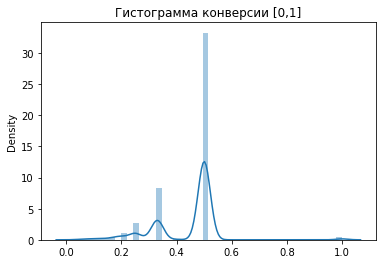

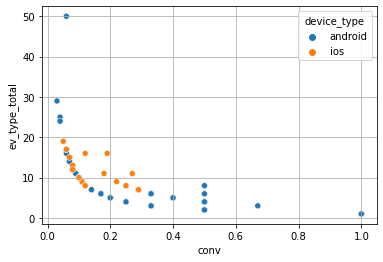

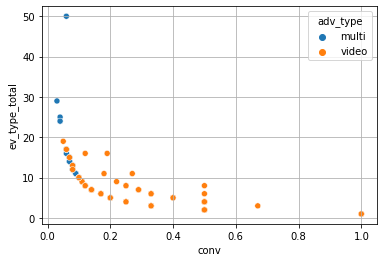

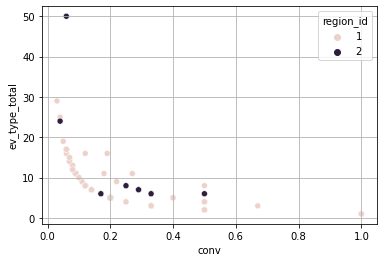

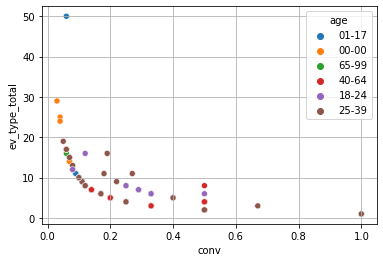

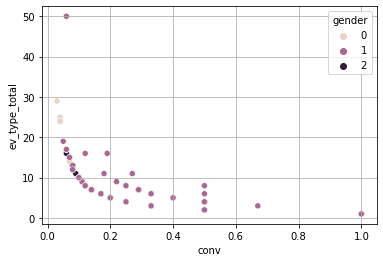

,device_id,ev_type_total
conv,,
0.03,1,29.0
0.04,3,24.0
0.05,1,19.0
0.06,6,17.0
0.07,7,15.0
0.08,10,12.0
0.09,3,11.0
0.10,6,10.0
0.11,8,9.0


In [11]:
df_conv = df2[df2['target']==1].copy()

df_conv0 = df_conv.drop(['ev_type','target','datetime'],axis=1) \
  .drop_duplicates('device_id') \
  .set_index('device_id')

df_conv1 = df_conv[df_conv['ev_type']==0].groupby('device_id')[['region_id']].count()
df_conv1.columns = ['ev_type0']

df_conv2 = df_conv[df_conv['ev_type']==1].groupby('device_id')[['target']].count()
df_conv2.columns = ['ev_type1']

df_conv = df_conv0.join(df_conv1).join(df_conv2).fillna(0)

df_conv['ev_type_total'] = (df_conv['ev_type0'] + df_conv['ev_type1'])
df_conv['conv'] = round( df_conv['ev_type1'] / df_conv['ev_type_total'] * 100)/100
print(df_conv.shape, df_conv.columns)

# Распределение кол-ва device_id по конверсии
sns.distplot(df_conv['conv'].values
             , kde=True
             )
plt.title( 'Гистограмма конверсии [0,1]' )
plt.show()

for col in ['device_type', 'adv_type', 'region_id', 'age', 'gender']:
  # Зависимость conv от общего числа показов
  sns.scatterplot( data=df_conv
                  , y='ev_type_total'
                  , x='conv'
                  , hue=col
                  )
  plt.grid(True)
  plt.show()

df_conv.reset_index().groupby(['conv']).agg({'device_id':'nunique',
                                             'ev_type_total':'median'
                                             })

## На основе конверсии:
- визуально выделяется группа, которая имеет конверсию = 0.5 всего при 2х показах

In [12]:
df_conv_top = df_conv[df_conv['conv']==0.5].reset_index() \
    .groupby(['device_type', 'adv_type', 'region_id', 'age', 'gender',
       'datetime:day_of_week', 'conv']) \
    .agg({'device_id':'nunique','ev_type_total':'median' }) \
    .reset_index() \
    .sort_values('device_id',ascending=False) \
    .reset_index(drop=True)

df_conv_top.columns = [x.replace('device_id','device_id_cnt') for x in df_conv_top.columns]
df_conv_top['device_id_share'] = round( df_conv_top['device_id_cnt'] / df_conv_top['device_id_cnt'].sum() * 100) 

print( f""" { df_conv_top.head(20)['device_id_share'].sum() }% входят в топ-20 профилей с конверсией 50%""" )

 73.0% входят в топ-20 профилей с конверсией 50%


## Вывод#0.  Целевое ядро с конверсией 50% - это top-20 профилей аудиторий:

In [13]:
df_conv_top.head(20)[['device_type', 'adv_type', 'region_id', 'age', 'gender','datetime:day_of_week',
        #'conv', 
       'device_id_share']]

,device_type,adv_type,region_id,age,gender,datetime:day_of_week,device_id_share
0,android,video,1,25-39,1,4,13.0
1,android,video,1,40-64,1,4,7.0
2,android,video,1,25-39,1,5,7.0
3,android,video,1,40-64,1,5,4.0
4,android,video,2,25-39,1,4,4.0
5,android,video,1,25-39,1,1,4.0
6,android,video,1,18-24,1,4,3.0
7,android,video,1,25-39,1,3,3.0
8,android,video,1,25-39,1,2,3.0
9,android,video,1,25-39,1,0,3.0


# 5. Подход следующий, смотрим только наблюдения "Клик", т.е. ev_type = 1. 
# Визуализируем двe группы device_id = android + ios

## Принимаем допущение, что данная выборка описывает генеральную совокупность

In [14]:
# Выберем только те наблюдения, в которых Девайс совершил "Клик":
df_data_1 = df2[ df2['ev_type']==1 ] \
    .drop(['target','ev_type'],axis=1)

# Посчитаем количество уникальных устройств по группам признаков:
df_summary = df_data_1.groupby(['device_type', 'adv_type', 'region_id', 'age', 'gender',
       #'datetime:day_of_week', 'datetime:hour'
       ])[['device_id']].nunique()  \
       .reset_index().sort_values('device_id',ascending=False) \
       .reset_index(drop=True)
df_summary.columns = [x.replace('device_id','device_id_count') for x in df_summary.columns]


# Доля устройств в каждой группе (строке):
df_summary['device_id_procent'] = round(df_summary['device_id_count'] / df_summary['device_id_count'].sum() * 10000) / 100

print('-----------------------------')
print(f"""{ round(df_summary.head(5)['device_id_procent'].sum()) }% устройств совершившие "Клик" входят в топ-5 аудиторий со следующими признаками:""" )
# df_summary.head(5)

-----------------------------
79% устройств совершившие "Клик" входят в топ-5 аудиторий со следующими признаками:


## Вывод#1.  Целевое ядро показа рекламы - top-5 кликабельных аудиторий:

In [15]:
df_summary.head(5)

,device_type,adv_type,region_id,age,gender,device_id_count,device_id_procent
0,android,video,1,25-39,1,1397,34.65
1,android,video,1,40-64,1,772,19.15
2,android,video,1,18-24,1,499,12.38
3,android,video,2,25-39,1,377,9.35
4,ios,video,1,25-39,1,142,3.52


## 5.1. device_type = android + ios

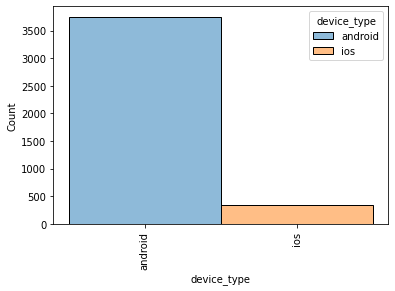

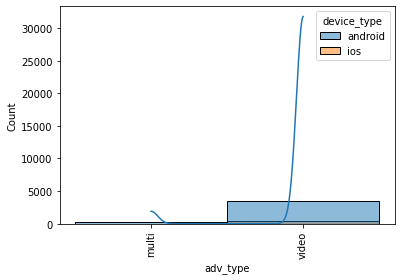

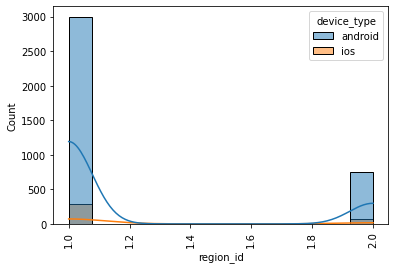

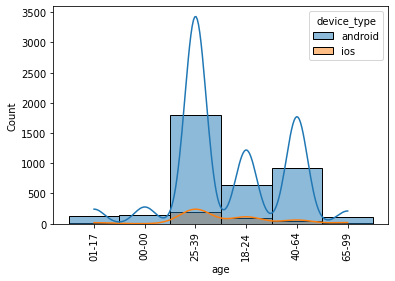

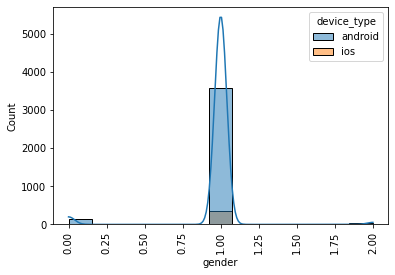

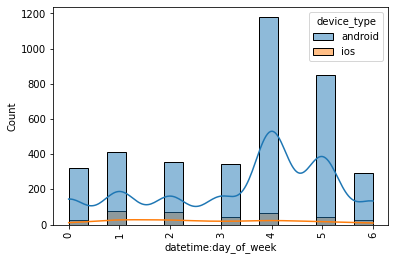

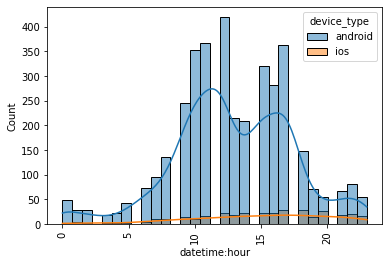

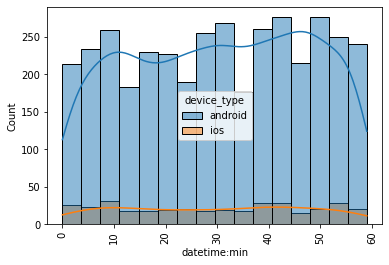

In [16]:
for col in df_data_1.drop(['device_id','datetime'],axis=1):
  sns.histplot(
        data = df_data_1.drop(['device_id'],axis=1)
        , x = col
        , kde = True
        , color = 'orange'
        , hue = 'device_type'
  )
  plt.xticks(rotation=90)
  plt.show()

## 5.2. device_type = android

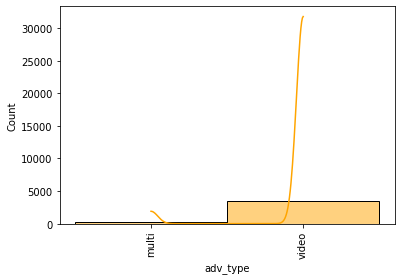

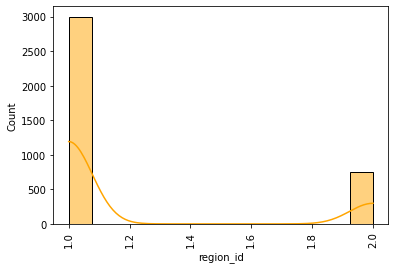

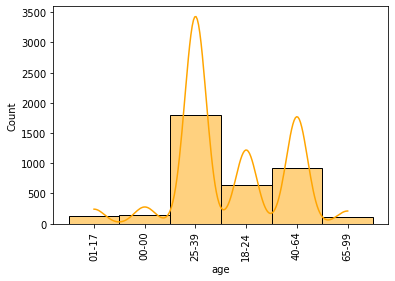

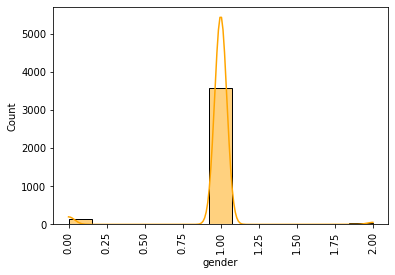

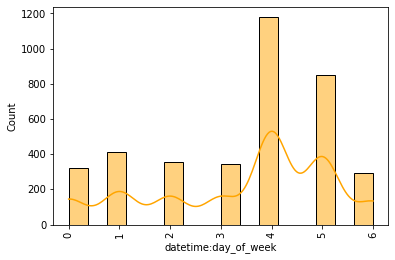

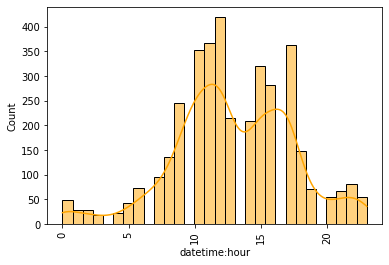

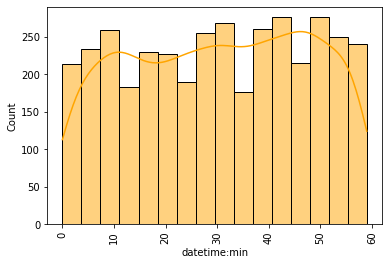

In [17]:
df_data_1 = df2[ (df2['ev_type']==1) & (df2['device_type']=='android')  ] \
    .drop(['device_id','target','ev_type','device_type','datetime'],axis=1)

for col in df_data_1.columns:
  sns.histplot(
        data = df_data_1
        , x = col
        , kde = True
        , color = 'orange'
  )
  plt.xticks(rotation=90)
  plt.show()

## Вывод#1.1. Для Android пользвователей конкретизировать ядро аудитории доп признаками:
- По дням недели: Пятница, Суббота
- По часам: с 9 до 19 часов

## 5.3. device_type = ios

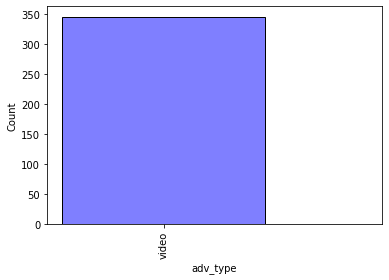

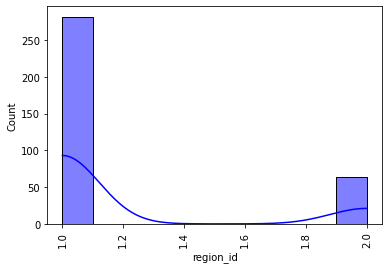

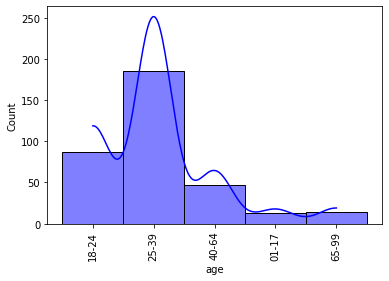

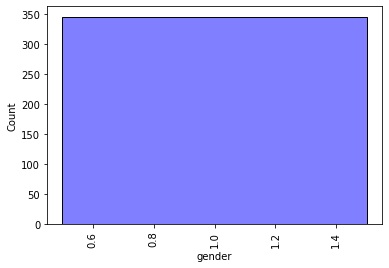

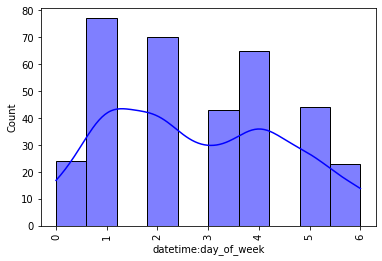

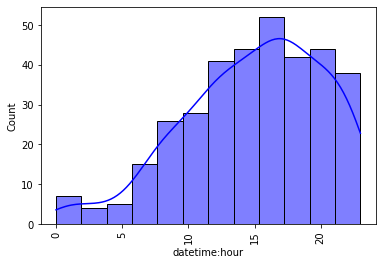

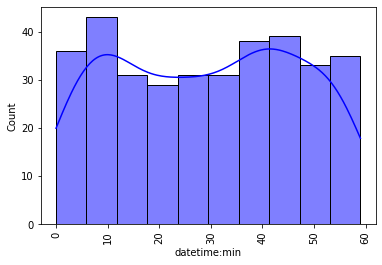

In [18]:
df_data_1 = df2[ (df2['ev_type']==1) & (df2['device_type']=='ios')  ] \
    .drop(['device_id','target','ev_type','device_type','datetime'],axis=1)

for col in df_data_1.columns:
  sns.histplot(
        data = df_data_1
        , x = col
        , kde = True
        , color = 'blue'
  )
  plt.xticks(rotation=90)
  plt.show()

## Вывод#1.2. Для iOS пользвователей конкретизировать ядро аудитории доп признаками:
- По дням недели: Вторник, Среда, Пятница
- По часам: с 12 до 21 часов

# 6. Проверим модели классификации - может покажет высокую точность?

## 6.1. Подготовка датасета к обучению моделей

In [19]:

from sklearn.preprocessing import LabelEncoder

df_data = df2.copy()

# # Сколько "Кликов" было всего?
# df_ev_type1 = df_data[df_data['ev_type']==1].copy()
# df_ev_type1 = df_ev_type1.groupby(['device_id']).agg({'target':'count','datetime':'min'}).reset_index()
# df_ev_type1.columns = ['device_id','ev_type1:count','ev_type1:datetime',]
# df_ev_type1

features_category = []
df_label = pd.DataFrame([])

# Категориальные признаки сделаем бинарными:
for col in ['device_type', 'adv_type','region_id']:
  le = LabelEncoder()
  df_data[f'{col}:binary'] = le.fit_transform(df_data[col])
  df_data[f'{col}:binary'] = df_data[f'{col}:binary'].astype("category")
  df_data = df_data.drop(col,axis=1)
  features_category.append(f'{col}:binary')
  df_label = df_label.append( 
          pd.DataFrame( 
                        np.array([ col, le.classes_[0], le.classes_[1] ]).reshape(-1,1)
                       ).T
                        
      )
  #print(col,'#', le.classes_[0],'--> 0','#', le.classes_[1],'--> 1')

# Пропуски в данных пола заменим на большинство = 1 (или бинарное = 0)
df_data['gender:binary'] = df_data['gender'].map(lambda x: 1 if x>1 else 0).astype("category")
features_category.append('gender:binary')

le = LabelEncoder()
df_data['age:category'] = le.fit_transform(df_data['age'])
df_data['age:category'] = df_data['age:category'].astype("category")

features_category.append('age:category')
df_label = df_label.append(pd.DataFrame( 
                        np.array([ 'age'
                                    , le.classes_[0]
                                    , le.classes_[1]
                                    , le.classes_[2]
                                    , le.classes_[3]
                                    , le.classes_[4]
                                    , le.classes_[5] ]
                                 ).reshape(-1,1)
                       ).T)

df_data = df_data.drop(['gender','age'],axis=1)

df_label.columns=['column','label_0','label_1','label_2','label_3','label_4','label_5']
df_label = df_label.reset_index(drop=True)

# Сколько было "Показов" на каждое  device_id:
df_ev_type0 = df_data[df_data['ev_type']==0].groupby(['device_id'])[['target']].count().reset_index()
df_ev_type0.columns = ['device_id','ev_type0:count']


df_data = df_data.merge(
    df_ev_type0
    , how = 'left'
    , on = 'device_id'
).fillna(0)

df_data = (df_data \
    #[df_data['ev_type']==1] \
    #.drop_duplicates('device_id') \
    .drop(['datetime','ev_type','datetime:min'],axis=1) \
    .reset_index(drop=True)
    )

df_data.head().T

,0,1,2,3,4
device_id,100001.0,100001.0,100002.0,100002.0,100003.0
target,0.0,0.0,0.0,0.0,0.0
datetime:day_of_week,4.0,4.0,4.0,4.0,4.0
datetime:hour,15.0,17.0,23.0,23.0,15.0
device_type:binary,0.0,0.0,0.0,0.0,0.0
adv_type:binary,0.0,0.0,0.0,0.0,0.0
region_id:binary,1.0,1.0,1.0,1.0,0.0
gender:binary,1.0,1.0,0.0,0.0,0.0
age:category,1.0,1.0,0.0,0.0,0.0
ev_type0:count,2.0,2.0,2.0,2.0,1.0


In [20]:
df_label

,column,label_0,label_1,label_2,label_3,label_4,label_5
0,device_type,android,ios,NaN,NaN,NaN,NaN
1,adv_type,multi,video,NaN,NaN,NaN,NaN
2,region_id,1,2,NaN,NaN,NaN,NaN
3,age,00-00,01-17,18-24,25-39,40-64,65-99


In [21]:
from sklearn.preprocessing import StandardScaler
 
sc = StandardScaler()
df_data_sc = sc.fit_transform( df_data[['datetime:day_of_week', 'datetime:hour',
                                      'ev_type0:count']] ) 
df_data_sc = pd.DataFrame( df_data_sc, columns = ['datetime:day_of_week', 'datetime:hour',
                                      'ev_type0:count'] )

df_data_sc = df_data[['device_id', 'target', 'device_type:binary', 'adv_type:binary',
       'region_id:binary', 'gender:binary', 'age:category' ]] .join( df_data_sc )

df_data_sc['target'] = df_data['target'].astype('int32')
df_data_sc['device_id'] = df_data['device_id'].astype('int32')

print('features_category:',features_category)
df_data_sc.head(3).T

features_category: ['device_type:binary', 'adv_type:binary', 'region_id:binary', 'gender:binary', 'age:category']


,0,1,2
device_id,100001.000000,100001.000000,100002.000000
target,0.000000,0.000000,0.000000
device_type:binary,0.000000,0.000000,0.000000
adv_type:binary,0.000000,0.000000,0.000000
region_id:binary,1.000000,1.000000,1.000000
gender:binary,1.000000,1.000000,0.000000
age:category,1.000000,1.000000,0.000000
datetime:day_of_week,0.325580,0.325580,0.325580
datetime:hour,0.327235,0.712689,1.869050
ev_type0:count,-0.110861,-0.110861,-0.110861


,device_id,target,datetime:day_of_week,datetime:hour,ev_type0:count
device_id,1.000000,0.029980,0.013391,0.051168,0.409429
target,0.029980,1.000000,0.001693,0.005274,0.030448
datetime:day_of_week,0.013391,0.001693,1.000000,0.157711,0.004873
datetime:hour,0.051168,0.005274,0.157711,1.000000,0.017869
ev_type0:count,0.409429,0.030448,0.004873,0.017869,1.000000


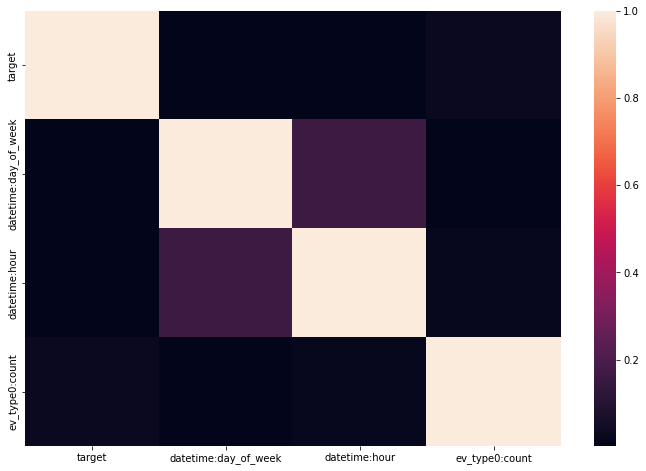

In [22]:
# Посмотрим корреляцию признаков
plt.figure(figsize=(12,8))
sns.heatmap( df_data_sc.drop('device_id',axis=1).corr().abs() )

df_data_sc.corr().abs()

In [23]:
from sklearn.model_selection import train_test_split

# Стандартное разделение TRAIN-TEST не подходит. Разделим по device_id:
X = df_data_sc[['device_id','target']].drop_duplicates('device_id')['device_id'].values
y = df_data_sc[['device_id','target']].drop_duplicates('device_id')['target'].values
id_train, id_test, _, _ = train_test_split(X, y , test_size=0.25, random_state=0)

X_train = df_data_sc[df_data_sc['device_id'].isin(id_train)] \
    .drop(['device_id','target'],axis=1) \
    .reset_index(drop=True)
X_test = df_data_sc[df_data_sc['device_id'].isin(id_test)] \
    .drop(['device_id','target'],axis=1) \
    .reset_index(drop=True)

y_train = df_data_sc[df_data_sc['device_id'].isin(id_train)]['target']
y_test = df_data_sc[df_data_sc['device_id'].isin(id_test)]['target']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(198476, 8) (66142, 8) (198476,) (66142,)


# 6.2. Предсказание моделей классификации

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [25]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier(max_depth=7)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(max_depth=7)

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier(n_neighbors=9)

import xgboost as xgb
models['XGB'] = xgb.XGBClassifier(
                                  #tree_method="gpu_hist",
                                  enable_categorical=False)

from catboost import CatBoostClassifier, Pool
models['CatBoost'] = CatBoostClassifier(iterations=500,
                           #task_type="GPU",
                           #devices='0:1',
                           cat_features = features_category,
                           verbose=False,
                           learning_rate=0.01)

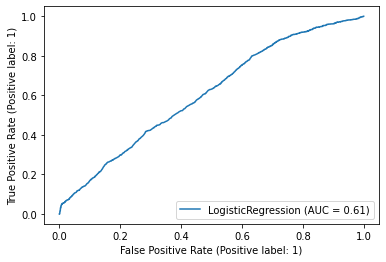

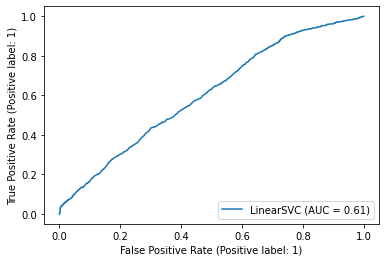

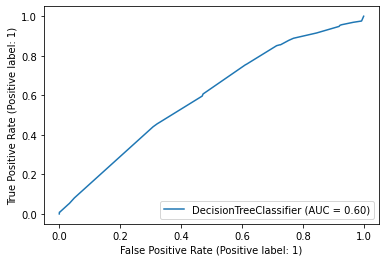

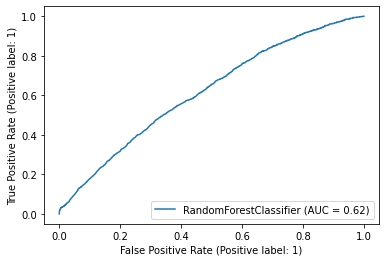

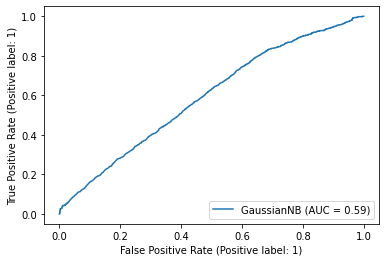

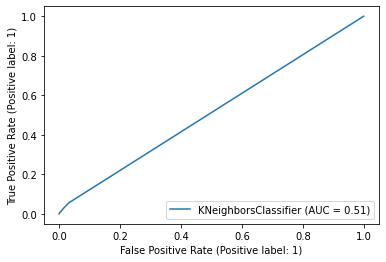

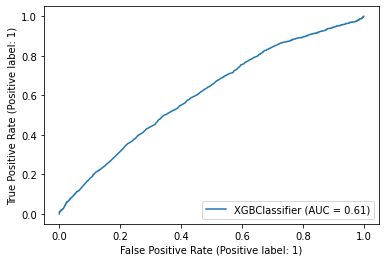

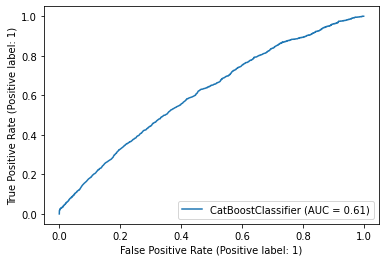

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, plot_roc_curve
from sklearn import metrics

accuracy, precision, recall, auc = {}, {}, {}, {}

for key in models.keys():
    
    if key != 'XGB':

      # Fit the classifier
      models[key].fit(X_train, y_train)
      # Make predictions
      predictions = models[key].predict(X_test)
      try:
        proba = models[key].predict_proba(X_test)[:,1].reshape(-1,1)
      except:
        proba = predictions
      plot_roc_curve(models[key], X_test, y_test) 

    else:
      
      models[key].fit(X_train.values, y_train)
      # Make predictions
      predictions = models[key].predict(X_test.values)
      proba = models[key].predict_proba(X_test.values)[:,1].reshape(-1,1)
      plot_roc_curve(models[key], X_test.values, y_test) 

    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predictions)
    precision[key] = precision_score(y_test, predictions)
    recall[key] = recall_score(y_test, predictions)
    auc[key] = roc_auc_score(y_test, proba)

    plt.show()

## Наиболее выгодно показали себя модель CatBoost:

In [27]:
df_model = pd.DataFrame(index=models.keys(),
                        columns=['AUC','Accuracy', 'Precision', 'Recall'])
df_model['AUC'] = auc.values()
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model.sort_values('AUC', ascending=False)

,AUC,Accuracy,Precision,Recall
Random Forest,0.615113,0.958151,1.000000,0.002163
CatBoost,0.612631,0.958196,1.000000,0.003244
XGB,0.608683,0.958196,1.000000,0.003244
Logistic Regression,0.605998,0.958060,0.000000,0.000000
Decision Trees,0.595641,0.958196,1.000000,0.003244
Naive Bayes,0.591206,0.950304,0.145228,0.037851
K-Nearest Neighbor,0.512431,0.957818,0.289474,0.003965
Support Vector Machines,0.500000,0.958060,0.000000,0.000000


# 6.3. Для подготовки новых гипотез дерево catboost:

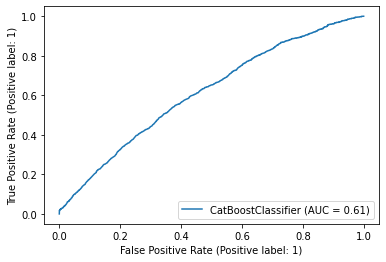

In [29]:
from catboost import CatBoostClassifier, Pool
clf = CatBoostClassifier(iterations=500,
                           #task_type="GPU",
                           #devices='0:1',
                           cat_features = features_category,
                           verbose=False,
                           learning_rate=0.01,
                           max_depth = 5,
                          custom_metric = 'AUC:hints=skip_train~false'
                         )

# Стандартное разделение TRAIN-TEST не подходит. Разделим по device_id:
X = df_data[['device_id','target']].drop_duplicates('device_id')['device_id'].values
y = df_data[['device_id','target']].drop_duplicates('device_id')['target'].values
id_train, id_test, _, _ = train_test_split(X, y , test_size=0.25, random_state=0)

X_train = df_data[df_data['device_id'].isin(id_train)] \
    .drop(['device_id','target'],axis=1) \
    .reset_index(drop=True)
X_test = df_data[df_data['device_id'].isin(id_test)] \
    .drop(['device_id','target'],axis=1) \
    .reset_index(drop=True)

y_train = df_data[df_data['device_id'].isin(id_train)]['target']
y_test = df_data[df_data['device_id'].isin(id_test)]['target']

clf.fit( X_train, y_train,
        eval_set=(X_test,y_test) )
plot_roc_curve(clf, X_test, y_test) 

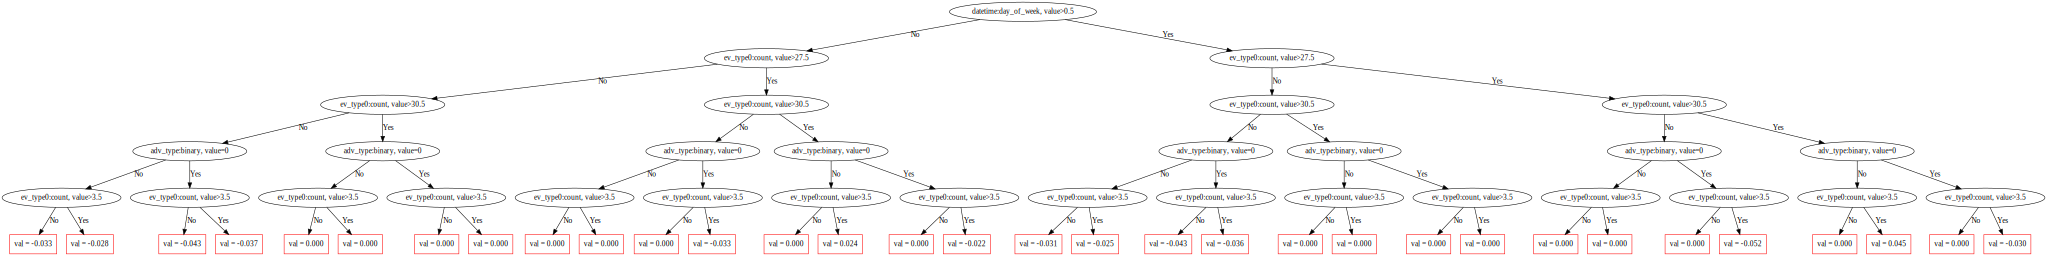

In [30]:
pool = Pool(X_train, y_train
            , cat_features=features_category
            , feature_names=list(X_train.columns)
            )
clf.plot_tree(tree_idx=0, pool=pool)